In [3]:
import numpy as np
import random 
import matplotlib.pyplot as plt

from tenpy.algorithms.truncation import svd_theta
from tenpy.networks.mps import MPS
from tenpy.models.model import CouplingMPOModel
from tenpy.networks.site import BosonSite

#from modules.myDMRG import SimpleDMRGEngine_Boson

In [10]:
# Module for myDMRG

import numpy as np

from tenpy.linalg import np_conserved as npc
from tenpy.linalg.lanczos import lanczos
from tenpy.linalg.sparse import NpcLinearOperator
from tenpy.algorithms.truncation import svd_theta

class SimpleDMRGEngine_Boson:
    """DMRG algorithm, implemented as class holding the necessary data.


        .->-vR            p*         vL->-.
        |                 ^               |
        |                 |               |
        (LP)->-wR   wL->-(W1)->-wR  wL->-(RP)
        |                 |               |
        |                 ^               |
        .-<-vR*           p         vL*-<-.
        
    Parameters
    ----------
    psi, model, chi_max, eps:
        See attributes

    Attributes
    ----------
    psi : SimpleMPS
        The current ground-state (approximation).
    model :
        The model of which the groundstate is to be calculated.
    chi_max, eps:
        Truncation parameters, see :func:`a_mps.split_truncate_theta`.
    LPs, RPs : list of np.Array[ndim=3]
        Left and right parts ("environments") of the effective Hamiltonian.
        ``LPs[i]`` is the contraction of all parts left of site `i` in the network ``<psi|H|psi>``,
        and similar ``RPs[i]`` for all parts right of site `i`.
        Each ``LPs[i]`` has legs ``vL wL* vL*``, ``RPS[i]`` has legs ``vR* wR* vR``
    """
    def __init__(self, psi, model, chi_max, eps):
        
        #assert psi.L == model.lat.mps_sites() #and psi.bc == model.bc  # ensure compatibility
        
        self.H_mpo = model.H_MPO
        self.psi = psi
        self.LPs = [None] * psi.L
        self.RPs = [None] * psi.L
        self.chi_max = chi_max
        self.eps = eps
        #self.Es = []
        
        # initialize left and right environment
        D = self.H_mpo.dim[0]   # IS IT CORRECT?
        chi = psi._B[0].shape[0]
        
        LP = np.zeros([chi, D, chi], dtype=float)  # vR wR vR*
        RP = np.zeros([chi, D, chi], dtype=float)  # vL* wL vL
        LP[:, 0, :] = np.eye(chi)
        RP[:, D - 1, :] = np.eye(chi)
        self.LPs[0] = npc.Array.from_ndarray(data_flat=LP, 
                                             legcharges=[self.psi._B[0].conj().get_leg('vL*'), # should have conj and then taken 'vL'
                                                         self.H_mpo.get_W(0).conj().get_leg('wL*'),
                                                         self.psi._B[0].get_leg('vL')],
                                             labels=['vR', 'wR', 'vR*'])
        self.RPs[-1] = npc.Array.from_ndarray(data_flat=RP, 
                                             legcharges=[self.psi._B[-1].get_leg('vR'), # should have conj and then taken 'vL'
                                                         self.H_mpo.get_W(-1).conj().get_leg('wR*'),
                                                         self.psi._B[-1].conj().get_leg('vR*')],
                                             labels=['vL*', 'wL', 'vL'])
        
        # initialize necessary RPs
        for i in range(psi.L - 1, 1, -1):
            self.update_RP(i)

    def sweep(self):
        
        EL = ER = 0
        # sweep from left to right
        for i in range(self.psi.L - 2): # 
            EL += self.update_bond(i)
            
        # sweep from right to left
        for i in range(self.psi.L - 2, 0, -1):
            ER += self.update_bond(i)
           
        return EL, ER

    def update_bond(self, i):
        
        j = (i + 1) % self.psi.L
        
        # Build H eff
        self.Heff = TwoSiteH(self, i)
        
        # Get theta
        th = self.psi.get_theta(i, n=2)
        
        # Contract with environment
        #th = self.Heff.matvec(th)
        #th = th.combine_legs([['vL', 'p0'], ['p1', 'vR']], qconj=[+1, -1]) # map to 2D
        
        #optimize with Lanczos Algorithm
        lanczos_params = {
            'cutoff':0.001,
            #'E_shift':,
            'E_tol': 1.e-10,
            #'min_gap':,
            'N_cache':10,
            #'N_max':,
            'N_min':10,
            #'P_tol':
            'reortho':True

        }
        
        # Diagonalize & find ground state
        E, th, N = lanczos(self.Heff,th,lanczos_params)
        
        th = th.combine_legs([['vL', 'p0'], ['p1', 'vR']], qconj=[+1, -1]) # map to 2D
        old_A = self.psi.get_B(i, form='A')
        U, S, VH, err, renormalize = svd_theta(th,
                                               {'chi_max' : self.chi_max},
                                               qtotal_LR=[old_A.qtotal, None],
                                               inner_labels=['vR','vL'])
        
        # Manipulate and put back into MPS
        U.ireplace_label('(vL.p0)', '(vL.p)')
        VH.ireplace_label('(p1.vR)', '(p.vR)')
        A = U.split_legs(['(vL.p)'])
        B = VH.split_legs(['(p.vR)'])
        self.psi.set_B(i, A, form='A')
        self.psi.set_B(i+1, B, form='B')
        self.psi.set_SR(i, S)
        
        # Update Environment
        self.update_LP(i)
        self.update_RP(j)
        return E

    def update_RP(self, i):
        """Calculate RP right of site `i-1` from RP right of site `i`."""
        j = (i - 1) % self.psi.L
        RP = self.RPs[i]  # vL* wL vL
        B = self.psi.get_B(i, form='B')  # vL p vR
        Bc = B.conj()  # vL* p* vR*
        W = self.H_mpo.get_W(i) # wL wR p p*
        RP = npc.tensordot(B, RP, axes=('vR', 'vL'))  # vL p [vR], [vL] wL vL*
        RP = npc.tensordot(RP, W, axes=(('p', 'wL'), ('p*', 'wR')))  # vL [p] [wL] vL*, wL [wR] p [p*]
        RP = npc.tensordot(RP, Bc, axes=(('vL*', 'p'), ('vR*', 'p*')))  # vL [vL*] wL [p], vL* [p*] [vR*]
        self.RPs[j] = RP  # vL wL vL*

    def update_LP(self, i):
        """Calculate LP left of site `i+1` from LP left of site `i`."""
        
        j = (i + 1) % self.psi.L
        LP = self.LPs[i]  # vR wR vR*
        A = self.psi.get_B(i, form='A')  # vL p vR
        Ac = A.conj()  # vL* p* vR*
        W = self.H_mpo.get_W(i)  # wL wR i i*
        LP = npc.tensordot(LP, A, axes=('vR', 'vL'))  # [vR] wR vR*, [vL] i vR
        LP = npc.tensordot(W, LP, axes=(('wL', 'p*'), ('wR', 'p')))  # [wL] wR p [p*], vR [wR] [p] vR*
        LP = npc.tensordot(Ac, LP, axes=(('vL*', 'p*'), ('vR*', 'p')))  # [vL*] [p*] vR*, vR [p] [vR*] wR
        self.LPs[j] = LP  # vR* wR vR (== vL wL* vL* on site i+1)

        
        
class TwoSiteH(NpcLinearOperator):
    r"""Class defining the two-site effective Hamiltonian for Lanczos.
    The effective two-site Hamiltonian looks like this::
            |        .---       ---.
            |        |    |   |    |
            |       LP----W0--W1---RP
            |        |    |   |    |
            |        .---       ---.
    If `combine` is True, we define `LHeff` and `RHeff`, which are the contractions of `LP` with
    `W0`, and `RP` with `W1`, respectively.
    Parameters
    ----------
    env : :class:`~tenpy.networks.mpo.MPOEnvironment`
        Environment for contraction ``<psi|H|psi>``.
    i0 : int
        Left-most site of the MPS it acts on.
    combine : bool
        Whether to combine legs into pipes. This combines the virtual and
        physical leg for the left site (when moving right) or right side (when moving left)
        into pipes. This reduces the overhead of calculating charge combinations in the
        contractions, but one :meth:`matvec` is formally more expensive, :math:`O(2 d^3 \chi^3 D)`.
    move_right : bool
        Whether the the sweep is moving right or left for the next update.
        Ignored for the :class:`TwoSiteH`.
    Attributes
    ----------
    i0 : int
        Left-most site of the MPS it acts on.
    combine : bool
        Whether to combine legs into pipes. This combines the virtual and
        physical leg for the left site and right site into pipes. This reduces
        the overhead of calculating charge combinations in the contractions,
        but one :meth:`matvec` is formally more expensive, :math:`O(2 d^3 \chi^3 D)`.
    length : int
        Number of (MPS) sites the effective hamiltonian covers.
    acts_on : list of str
        Labels of the state on which `self` acts. NB: class attribute.
        Overwritten by normal attribute, if `combine`.
    LHeff : :class:`~tenpy.linalg.np_conserved.Array`
        Left part of the effective Hamiltonian.
        Labels ``'(vR*.p0)', 'wR', '(vR.p0*)'`` for bra, MPO, ket.
    RHeff : :class:`~tenpy.linalg.np_conserved.Array`
        Right part of the effective Hamiltonian.
        Labels ``'(p1*.vL)', 'wL', '(p1.vL*)'`` for ket, MPO, bra.
    LP, W0, W1, RP : :class:`~tenpy.linalg.np_conserved.Array`
        Tensors making up the network of `self`.
    """
    length = 2
    acts_on = ['vL', 'p0', 'p1', 'vR']

    def __init__(self, eng, i0):
        #self.i0 = i0
        self.LP = eng.LPs[i0]
        self.RP = eng.RPs[i0 + 1]
        self.W0 = eng.H_mpo.get_W(i0).replace_labels(['p', 'p*'], ['p0', 'p0*'])
        # 'wL', 'wR', 'p0', 'p0*'
        self.W1 = eng.H_mpo.get_W(i0 + 1).replace_labels(['p', 'p*'], ['p1', 'p1*'])
        # 'wL', 'wR', 'p1', 'p1*'
        self.dtype = eng.H_mpo.dtype
        #self.N = (self.LP.get_leg('vR').ind_len * self.W0.get_leg('p0').ind_len *
        #          self.W1.get_leg('p1').ind_len * self.RP.get_leg('vL').ind_len)

    def matvec(self, theta):
        """Apply the effective Hamiltonian to `theta`.
        Parameters
        ----------
        theta : :class:`~tenpy.linalg.np_conserved.Array`
            Labels: ``vL, p0, p1, vR`` if combine=False, ``(vL.p0), (p1.vR)`` if True
        Returns
        -------
        theta :class:`~tenpy.linalg.np_conserved.Array`
            Product of `theta` and the effective Hamiltonian.
        """
        labels = theta.get_leg_labels()
        theta = npc.tensordot(self.LP, theta, axes=['vR', 'vL'])
        theta = npc.tensordot(self.W0, theta, axes=[['wL', 'p0*'], ['wR', 'p0']])
        theta = npc.tensordot(theta, self.W1, axes=[['wR', 'p1'], ['wL', 'p1*']])
        theta = npc.tensordot(theta, self.RP, axes=[['wR', 'vR'], ['wL', 'vL']])
        theta.ireplace_labels(['vR*', 'vL*'], ['vL', 'vR'])
        theta.itranspose(labels)  # if necessary, transpose
        return theta



# Model

In [11]:
class myModel(CouplingMPOModel):
    
    def init_sites(self, model_params):
        n_max = model_params.get('n_max', 0)
        filling = model_params.get('filling', 0)
        conserve = model_params.get('conserve', 'N')
        if conserve == 'best':
            conserve = 'N'
            self.logger.info("%s: set conserve to %s", self.name, conserve)
        site = BosonSite(Nmax=n_max, conserve=conserve, filling=filling)
        return site

    def init_terms(self, model_params):
        
        # 0) Read and set parameters.
        rc = model_params.get('rc', 0)
        t = model_params.get('t', 1.)
        U = model_params.get('U', 0.)
        V = model_params.get('V', 0.)
        mu = model_params.get('mu', 0)
        
        for u1, u2, dx in self.lat.pairs['nearest_neighbors']:
            self.add_coupling(-t, u1, 'Bd', u2, 'B', dx, plus_hc=True)
        for dx in range(1,rc+1):
            self.add_coupling(V, 0, 'N', 0, 'N', dx)

### Initialize

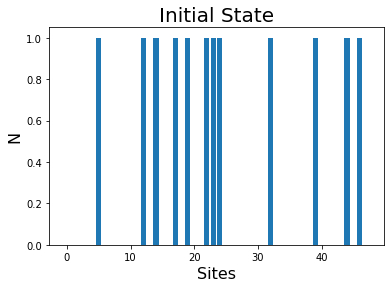

In [27]:
avg_n = 1/4
model_params = {
    'L':48, 
    'n_max':1, 
    't':1, 
    'V':100, 
    'rc':4, 
    'conserve':'N', 
    'filling':avg_n, 
    'bc_MPS':'finite', 
    'bc_x':'periodic'
}

#initialize model
M = myModel(model_params)

#initialize state
product_state = ['1']*int(M.lat.N_sites*avg_n) + ['vac']*int(M.lat.N_sites*(1-avg_n))
random.shuffle(product_state)
psi = MPS.from_product_state(M.lat.mps_sites(), product_state, bc=M.lat.bc_MPS)

#plot initial state
plt.figure(1)
plt.bar(range(model_params.get('L')), psi.expectation_value('N'))
plt.title("Initial State",fontsize=20)
plt.xlabel("Sites",fontsize=16)
plt.ylabel("N",fontsize=16)
plt.show()

In [28]:
#define the Engine
eng = SimpleDMRGEngine_Boson(psi, M, chi_max=30, eps=1.e-10)

#perform sweeps
n_sweeps = 7
E1, E2 =2, 0

i=0
while (E1-E2)>1e-6:
    print("SWEEP",i)
    E1, E2 = eng.sweep()
    print(E1,E2)
    i+=1

SWEEP 0
37106.554682392576 27508.72414951494
SWEEP 1
19619.704563437237 18177.267397166634
SWEEP 2
18144.263533158653 18115.924185133634
SWEEP 3
18103.830714136242 18080.335625342494
SWEEP 4
18075.283592817974 15140.119779664243
SWEEP 5
13821.526603460716 13792.178657575207
SWEEP 6
13792.178657575207 13792.178657575203


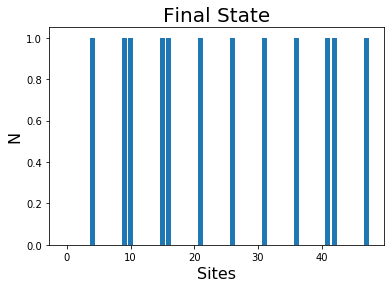

In [29]:
#plot final state
plt.figure(2)
plt.bar(range(model_params.get('L')), psi.expectation_value('N'))
plt.title("Final State",fontsize=20)
plt.xlabel("Sites",fontsize=16)
plt.ylabel("N",fontsize=16)
plt.show()

# Structure Factor

In [30]:
def structure_factor(k, psi, model_params):
    
    L = model_params.get('L')
    corr_matrix = psi.correlation_function('N','N')# - model_params.get('filling')**2
    res = 0 
    j = 0+1j
    for ii in range(L):
        for jj in range(L):
            res += (corr_matrix[ii,jj]/L) * np.exp(j*k*(ii-jj))
    return res

# Density-Density Correlations

In [42]:
def g_2(psi, model_params):
    L = model_params.get('L', 0)
    corr_matrix = psi.correlation_function('N','N') #- model_params.get('filling')**2
    out = np.zeros(L)
    norm = np.zeros(L)
    for ii in range(L):
        for jj in range(L):
            out[abs(ii-jj)] += corr_matrix[ii,jj]
            norm[abs(ii-jj)] += 1
    return out/norm

# Figure 1

In [40]:
#set model params
model_params = {
    'L':48, 
    'n_max':1, 
    't':1, 
    'V':100, 
    'rc':0, 
    'conserve':'N', 
    'filling':avg_n, 
    'bc_MPS':'finite', 
    'bc_x':'periodic',
}

#run DMRG for 3 different rcs
rcs = [2,3,4]

#list of results
PSI = []

DeltaE = [1,1e-4,1e-10]

for i,r in enumerate(rcs):
    
    print("Training Model with rc=",r)
    
    #insert value in dict
    model_params['rc'] = r
    
    #initialize model
    M = myModel(model_params)

    #initialize state
    product_state = ['1']*int(M.lat.N_sites*avg_n) + ['vac']*int(M.lat.N_sites*(1-avg_n))
    random.shuffle(product_state)
    psi = MPS.from_product_state(M.lat.mps_sites(), product_state, bc=M.lat.bc_MPS)
    
    #define the Engine
    eng = SimpleDMRGEngine_Boson(psi, M, chi_max=30, eps=1.e-10)

    #perform sweeps
    E1, E2 = 2,0
    j=0

    while(E1-E2)>DeltaE[i]:
        print("SWEEP",j)
        E1,E2 = eng.sweep()
        print(E1,E2)
        j+=1
        
    #store result
    PSI.append(psi)



Training Model with rc= 2
SWEEP 0
15688.16137819013 7730.117983280053
SWEEP 1
1782.4658597843231 226.78644599637826
SWEEP 2
-620.1990304143899 -680.0773199390964
SWEEP 3
-689.7937710450078 -693.6087668575618
SWEEP 4
-700.8275244176735 -702.5568660141764
SWEEP 5
-703.1225028195717 -704.0818357420695
Training Model with rc= 3
SWEEP 0
36215.674509177494 19921.322410912664
SWEEP 1
16787.216597930463 13479.652939467975
SWEEP 2
11694.1182926633 8931.72316511406
SWEEP 3
8855.396679312258 8785.892453984145
SWEEP 4
7247.75169397576 4371.936743303626
SWEEP 5
4355.98284415764 4341.769985912009
SWEEP 6
3678.1163726277296 625.9815854793043
SWEEP 7
-10.582025488282559 -10.582025488282529
Training Model with rc= 4
SWEEP 0
30457.20536595663 29190.5890832412
SWEEP 1
24506.775943878205 21022.02610674958
SWEEP 2
17641.045234414258 13792.17911525173
SWEEP 3
13792.178699269518 13792.178673487568
SWEEP 4
13792.178671441208 13792.178671441205


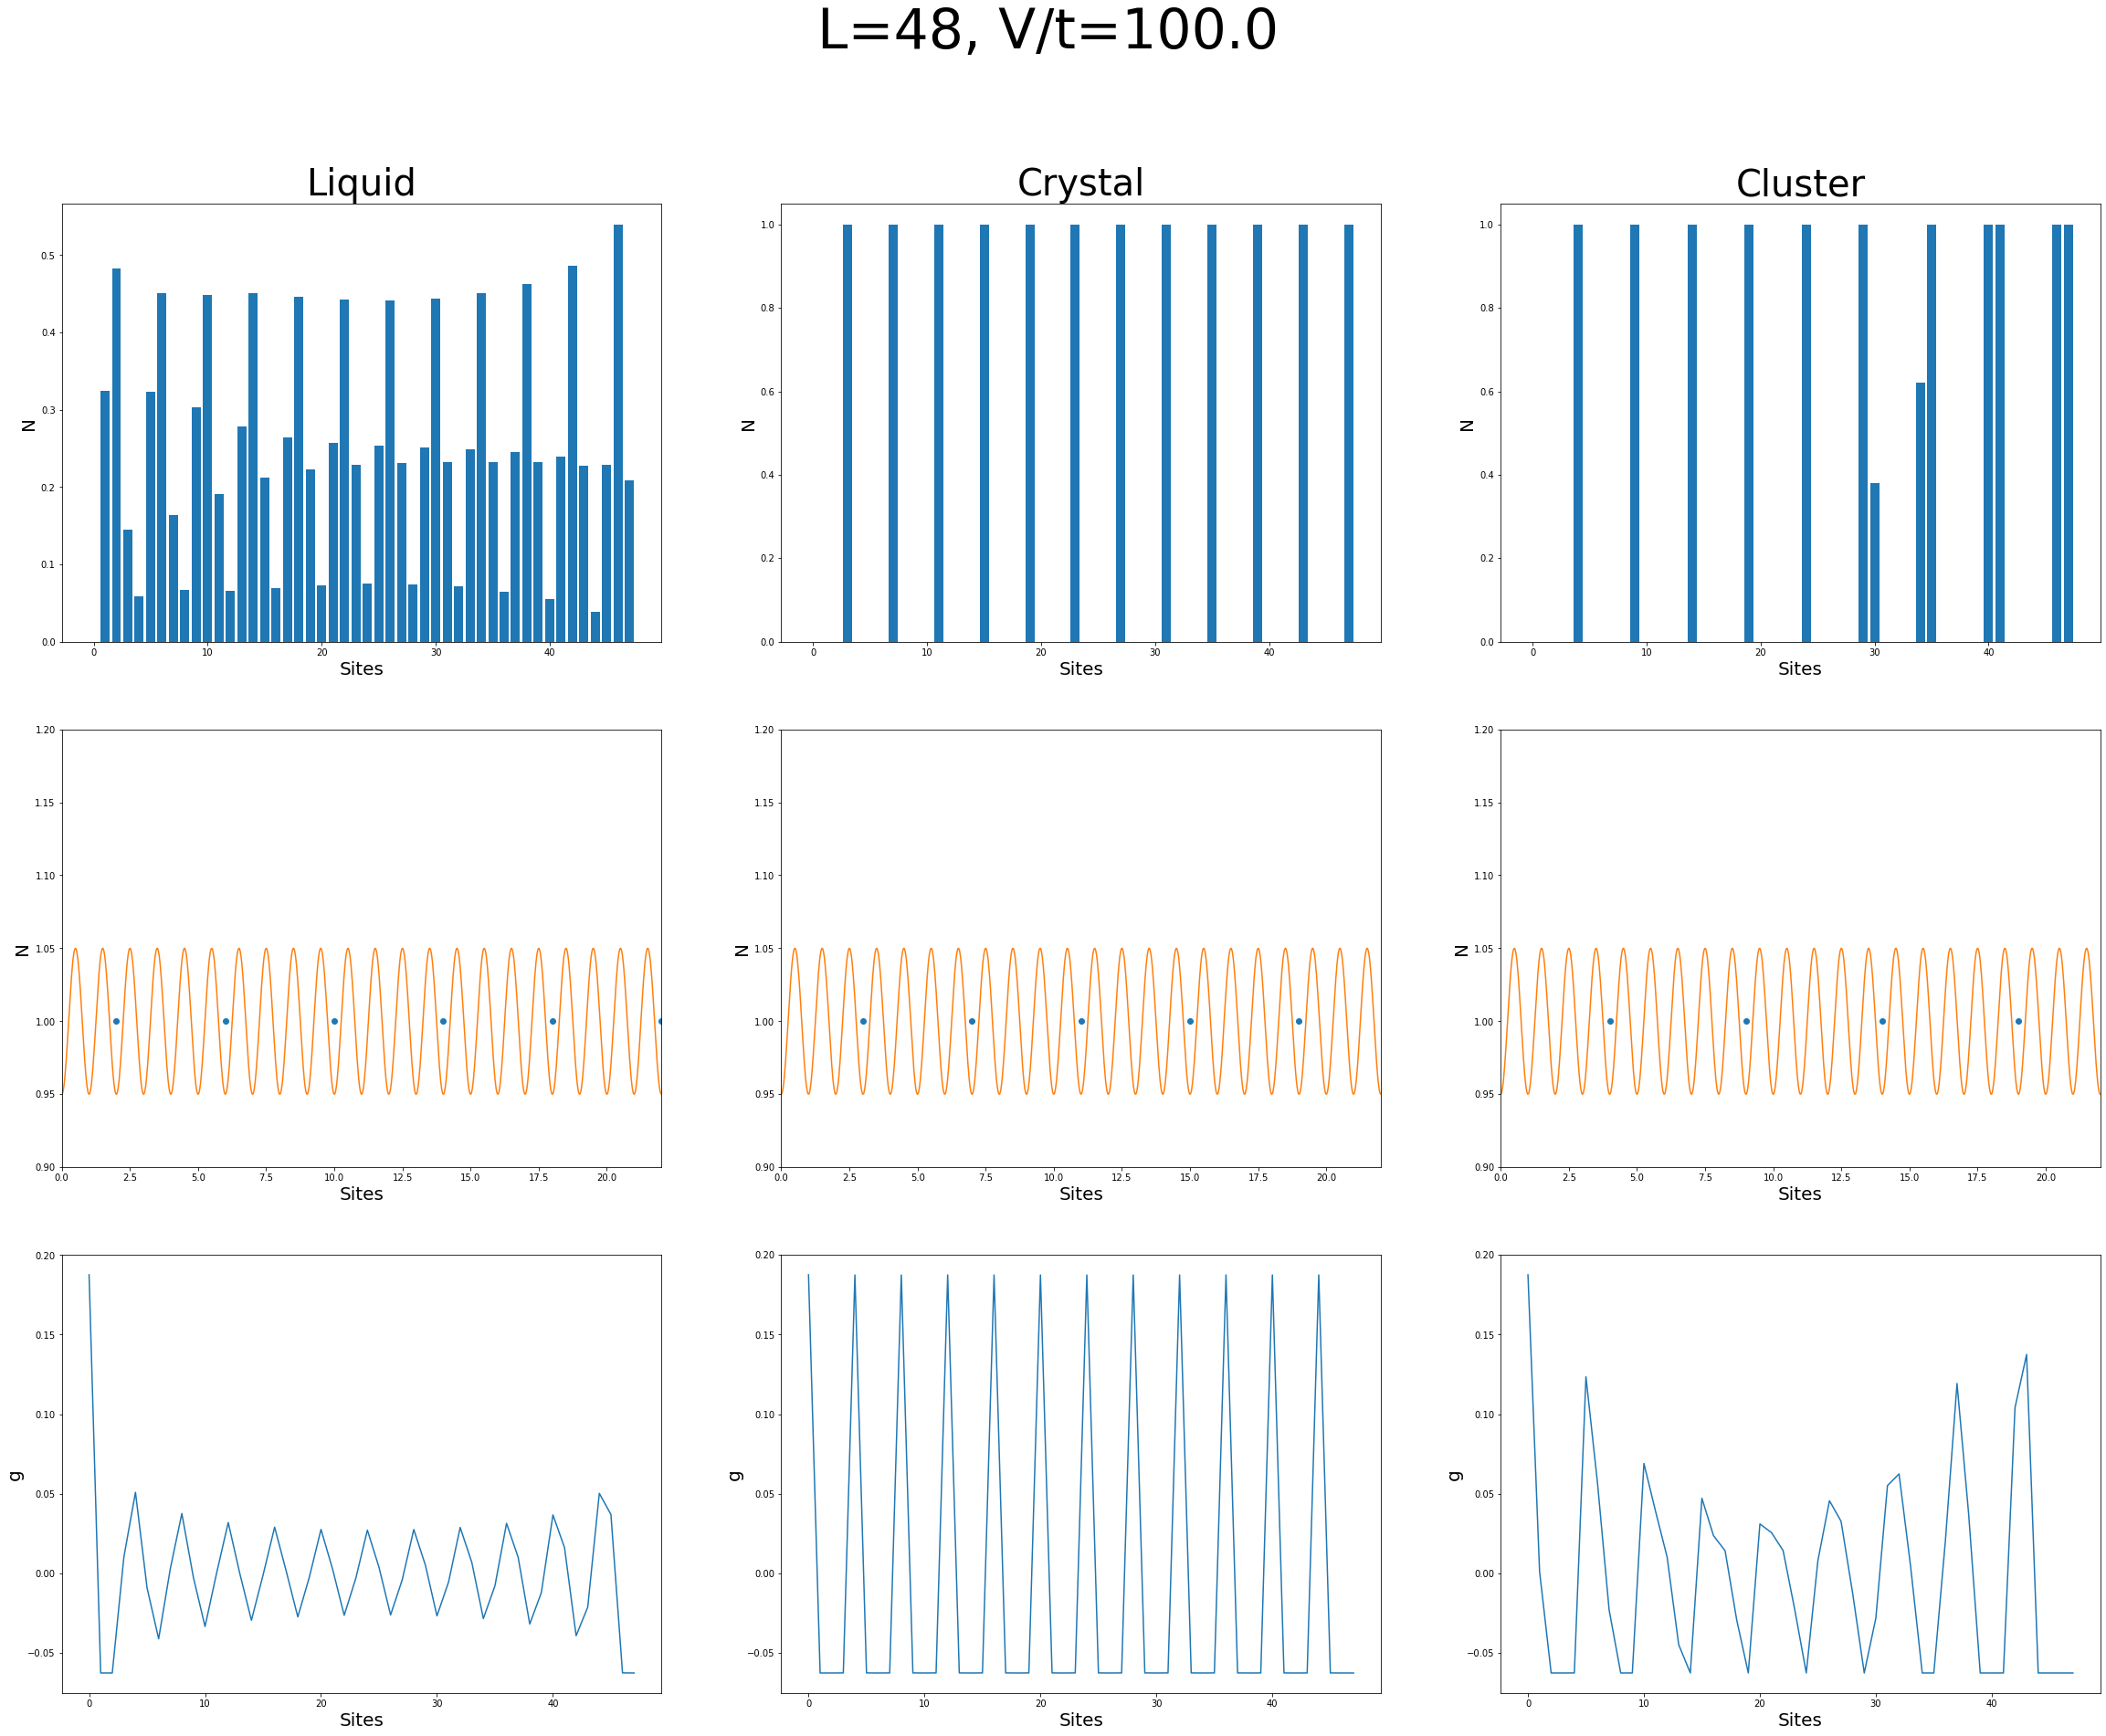

In [43]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(40,30))

states = ['Liquid','Crystal','Cluster']




for i, rc in enumerate(rcs):
    
    #select the proper state
    psi = PSI[i]
    
    #plot expectation value of N
    ax[0,i].bar(range(model_params.get('L')), psi.expectation_value('N'))
    ax[0,i].set_title(f"{states[i]}",fontsize=40)
    ax[0,i].set_xlabel("Sites",fontsize=20)
    ax[0,i].set_ylabel("N",fontsize=20)
    
    #plot sinusoids
    xlim_sx = [0,22] #plotting range
    x = np.linspace(xlim_sx[0],xlim_sx[1],1000)
    gs = psi.expectation_value('N')
    mask = gs>0.39 #modify accordingly with the results
    y = np.ones(model_params.get('L'))[mask]
    ax[1,i].plot(np.arange(model_params.get('L'))[mask], y, 'o')
    ax[1,i].plot(x, 1-np.cos(x*np.pi*2)/20)
    ax[1,i].set_xlim(xlim_sx)
    ax[1,i].set_ylim(0.9,1.2)
    ax[1,i].set_xlabel("Sites",fontsize=20)
    ax[1,i].set_ylabel("N",fontsize=20)
    
    #plot density-density correlation
    x = np.arange(model_params.get('L'))
    y = g_2(psi, model_params)
    ax[2,i].plot(x, y)
    ax[2,i].set_xlabel("Sites",fontsize=20)
    ax[2,i].set_ylabel("g",fontsize=20)
    
        
        
plt.suptitle(f"L={model_params.get('L')}, V/t={model_params.get('V')/model_params.get('t')}",fontsize=60)
plt.show()
        

# Structure factor for fixed filling and variable V/t

In [47]:
avg_N = 3/4

#set model params
model_params = {
    'L':48, 
    'n_max':1, 
    't':1, 
    'V':1, 
    'rc':4, 
    'conserve':'N', 
    'filling':avg_n, 
    'bc_MPS':'finite', 
    'bc_x':'periodic',
}

#run DMRG for 3 different rcs
Vs = [1,3,5,100]


#list of results
PSI = []

#number of sweeps
#n_sweeps = [10,4,5]
DeltaE = [1,1,1,1]

for i,V in enumerate(Vs):
    
    print("Training Model with V=",V)
    
    #insert value in dict
    model_params['V'] = V
    
    #initialize model
    M = myModel(model_params)

    #initialize state
    product_state = ['1']*int(M.lat.N_sites*avg_n) + ['vac']*int(M.lat.N_sites*(1-avg_n))
    random.shuffle(product_state)
    psi = MPS.from_product_state(M.lat.mps_sites(), product_state, bc=M.lat.bc_MPS)
    
    #define the Engine
    eng = SimpleDMRGEngine_Boson(psi, M, chi_max=30, eps=1.e-10)

    #perform sweeps
    E1, E2 = 2,0
    j=0
    while(E1-E2)>DeltaE[i]:
        print("SWEEP",j)
        E1, E2 = eng.sweep()
        print(E1,E2)
        j+=1
        
    #store result
    PSI.append(psi)




Training Model with V= 1
SWEEP 0
206.03225577242526 -326.3798859035886
SWEEP 1
-551.1593266045526 -592.776333432641
SWEEP 2
-621.9428448856917 -626.0911462236887
SWEEP 3
-630.7224073714806 -633.5384497448591
SWEEP 4
-637.5674935385775 -639.0254382224231
SWEEP 5
-639.4450897691908 -639.5274848226563
Training Model with V= 3
SWEEP 0
874.8296347764573 276.34172316020164
SWEEP 1
148.05433223075016 44.61231692842219
SWEEP 2
17.9134006907446 -0.6704435455762164
SWEEP 3
-5.518202263530783 -7.279700599929692
SWEEP 4
-10.971809077219785 -15.928712789533659
SWEEP 5
-18.8349953688448 -20.02064086758287
SWEEP 6
-20.441418305070375 -20.658360757495448
Training Model with V= 5
SWEEP 0
1898.222020522239 936.704425024447
SWEEP 1
552.6840255234995 509.4214047037504
SWEEP 2
481.52592617421243 470.1655342196058
SWEEP 3
467.6734252514978 467.0281177023193
Training Model with V= 100
SWEEP 0
38603.87987079174 27219.43864147404
SWEEP 1
18180.522549209814 18165.73351887478
SWEEP 2
18124.401519843916 18091.502

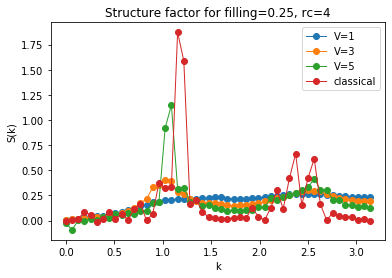

In [50]:
k = np.linspace(0,np.pi,50)
y = []
for i in range(4):
    psi = PSI[i]
    y.append(np.real(structure_factor(k, psi, model_params)))

plt.figure(1)
plt.title(f"Structure factor for filling={avg_n}, rc=4")
plt.plot(k,y[0],'o-',label="V=1",linewidth=1)
plt.plot(k,y[1],'o-',label="V=3",linewidth=1)
plt.plot(k,y[2],'o-',label="V=5",linewidth=1)
plt.plot(k,y[3],'o-',label="classical",linewidth=1)
plt.xlabel("k")
plt.ylabel("S(k)")
plt.legend()
plt.show()


# Structure factor for fixed V/t=1.5 and varying rc

In [142]:
avg_n = 3/4

#set model params
model_params = {
    'L':48, 
    'n_max':1, 
    't':2, 
    'V':3, 
    'rc':0, 
    'conserve':'N', 
    'filling':avg_n, 
    'bc_MPS':'finite', 
    'bc_x':'periodic',
}

#run DMRG for 3 different rcs
rcs = [1,2,3,4,5]

#list of results
PSI = []

#number of sweeps
n_sweeps = [4,4,4,4,4]

for i,r in enumerate(rcs):
    
    print("Training Model with rc=",r)
    
    #insert value in dict
    model_params['rc'] = r
    
    #initialize model
    M = myModel(model_params)

    #initialize state
    product_state = ['1']*int(M.lat.N_sites*avg_n) + ['vac']*int(M.lat.N_sites*(1-avg_n))
    random.shuffle(product_state)
    psi = MPS.from_product_state(M.lat.mps_sites(), product_state, bc=M.lat.bc_MPS)
    
    #define the Engine
    eng = SimpleDMRGEngine_Boson(psi, M, chi_max=30, eps=1.e-10)

    #perform sweeps

    for j in range(n_sweeps[i]):
        print("SWEEP",j)
        eng.sweep()
        
        
        
    #store result
    PSI.append(psi)

Training Model with rc= 1
SWEEP 0
2671.2958718041514 1791.1265169616995
SWEEP 1
1518.263352035808 1459.758913948026
SWEEP 2
1413.922939563207 1400.3795171241982
SWEEP 3
1387.9292358957257 1381.6661074204346
Training Model with rc= 2
SWEEP 0
6649.541854768876 5469.034536658914
SWEEP 1
5205.888533672409 5046.555446106629
SWEEP 2
4959.857989982031 4927.80366619406
SWEEP 3
4894.344604521603 4882.769437958084
Training Model with rc= 3
SWEEP 0
10155.350642699472 9092.531433845852
SWEEP 1
8745.903760355994 8650.467843223609
SWEEP 2
8597.433798649114 8579.48488414299
SWEEP 3
8568.494566032641 8562.529253097842
Training Model with rc= 4
SWEEP 0
13495.063987099433 12580.663211400552
SWEEP 1
12405.710771902777 12369.446870055808
SWEEP 2
12340.69742468073 12325.89261032189
SWEEP 3
12317.410840276734 12311.118932486499
Training Model with rc= 5
SWEEP 0
17567.944087053078 16559.728472791317
SWEEP 1
16259.117363379106 16119.053305964397
SWEEP 2
16064.15274685283 16019.335750723958
SWEEP 3
16009.68034

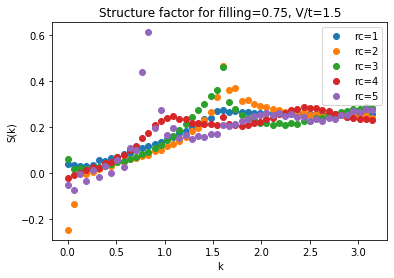

In [146]:
k = np.linspace(0,np.pi,50)
y = []
for i in range(5):
    psi = PSI[i]
    y.append(np.real(structure_factor(k, psi, model_params)))

plt.figure(2)
plt.title(f"Structure factor for filling={avg_n}, V/t=1.5")
plt.plot(k,y[0],'o',label="rc=1")
plt.plot(k,y[1],'o',label="rc=2")
plt.plot(k,y[2],'o',label="rc=3")
plt.plot(k,y[3],'o',label="rc=4")
plt.plot(k,y[4],'o',label="rc=5")
plt.xlabel("k")
plt.ylabel("S(k)")
plt.legend()
plt.show()


# Evolution of static structure factor as a function of V/t

In [69]:
avg_n = 1/4

#set model params
model_params = {
    'L':48, 
    'n_max':1, 
    't':1, 
    'V':4, 
    'rc':4, 
    'conserve':'N', 
    'filling':avg_n, 
    'bc_MPS':'finite', 
    'bc_x':'periodic',
}


#list of results
PSI = []

#potentials
Vs = [0.5,1,1.5,2,2.5,3,4,100]

#iteration over different rc
for i,V in enumerate(Vs):
    
    print(f"Training Model with V={V}")

    #insert value in dict
    model_params['V'] = V

    #initialize model
    M = myModel(model_params)

    #initialize state
    product_state = ['1']*int(M.lat.N_sites*avg_n) + ['vac']*int(M.lat.N_sites*(1-avg_n))
    random.shuffle(product_state)
    psi = MPS.from_product_state(M.lat.mps_sites(), product_state, bc=M.lat.bc_MPS)

    #define the Engine
    eng = SimpleDMRGEngine_Boson(psi, M, chi_max=30, eps=1.e-10)

    #perform sweeps
    E1,E2 = 2,0
    k=0
    while(E1-E2)>1: 
        print("SWEEP",k)
        E1,E2 = eng.sweep()
        print(E1,E2)
        k+=1

    #store result
    PSI.append(psi)

Training Model with V=0.5
SWEEP 0
-167.7846596770604 -674.5121851335092
SWEEP 1
-773.6034746179107 -795.5079977666522
SWEEP 2
-802.5503344058604 -804.7495673809742
SWEEP 3
-809.4615060067608 -812.6524980666111
SWEEP 4
-813.1803820499215 -813.21555603585
Training Model with V=1
SWEEP 0
116.58569890067936 -368.52135448044123
SWEEP 1
-536.6523422847993 -595.0124995306545
SWEEP 2
-619.9003797553181 -628.3884608647886
SWEEP 3
-631.4429732066493 -635.6381432377378
SWEEP 4
-638.9088673914243 -639.5506409913911
Training Model with V=1.5
SWEEP 0
340.7105540038368 -230.5428361079921
SWEEP 1
-357.59258895736406 -413.114394695053
SWEEP 2
-435.1566517014279 -452.43901263554693
SWEEP 3
-459.3447649416032 -464.4470843941924
SWEEP 4
-467.8744552459385 -470.21985049228977
SWEEP 5
-471.3941988634168 -472.21838190483066
Training Model with V=2
SWEEP 0
793.2249014349843 117.09889542130087
SWEEP 1
-71.68559531512093 -187.6936441392107
SWEEP 2
-235.07649285799738 -270.2700075028189
SWEEP 3
-283.964139309508

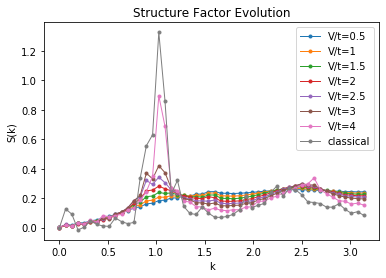

In [70]:
k = np.linspace(0,np.pi,50)
y = []
for i in range(len(Vs)):
    psi = PSI[i]
    y.append(np.real(structure_factor(k, psi, model_params)))

plt.figure(3)
for i in range(len(Vs)-1):
    plt.plot(k,y[i],'.-',linewidth=1,label=f"V/t={Vs[i]}")
plt.plot(k,y[-1],'.-',linewidth=1,label="classical")
plt.title("Structure Factor Evolution")
plt.xlabel("k")
plt.ylabel("S(k)")
plt.legend()
plt.show()

# Result for general densities

In [67]:
avg_n = 1/4

#set model params
model_params = {
    'L':48, 
    'n_max':1, 
    't':1, 
    'V':4, 
    'rc':0, 
    'conserve':'N', 
    'filling':avg_n, 
    'bc_MPS':'finite', 
    'bc_x':'periodic',
}


#list of results
PSI = []

# Results for different densities
avg_ns = [2/3,3/4]

#run DMRG for 3 different rcs
rcs = [2,3,4,5]

#iteration over different rc
for i,r in enumerate(rcs):
    
    #iteration for different densities
    for j,n in enumerate(avg_ns):
    
        print(f"Training Model with rc={r},filling={n}")

        #insert value in dict
        model_params['rc'] = r
        model_params['filling'] = n
        avg_n = n

        #initialize model
        M = myModel(model_params)

        #initialize state
        product_state = ['1']*int(M.lat.N_sites*avg_n) + ['vac']*int(M.lat.N_sites*(1-avg_n))
        random.shuffle(product_state)
        psi = MPS.from_product_state(M.lat.mps_sites(), product_state, bc=M.lat.bc_MPS)

        #define the Engine
        eng = SimpleDMRGEngine_Boson(psi, M, chi_max=30, eps=1.e-10)

        #perform sweeps
        E1,E2 = 2,0
        k=0
        while(E1-E2)>1: 
            print("SWEEP",k)
            E1,E2 = eng.sweep()
            print(E1,E2)
            k+=1

        #store result
        PSI[i].append(psi)


Training Model with rc=2,filling=0.6666666666666666
SWEEP 0
6569.844454758997 5937.195220980427
SWEEP 1
5726.186170980476 5603.968483667065
SWEEP 2
5518.745851512691 5496.041711081752
SWEEP 3
5482.04444094975 5474.70282518846
SWEEP 4
5473.505884806924 5472.469331516055
SWEEP 5
5471.940401063375 5471.699805373009
Training Model with rc=2,filling=0.75
SWEEP 0
10082.803810777114 8784.68223213926
SWEEP 1
8458.738530640725 8243.15979507179
SWEEP 2
8146.734881555589 8110.836257938399
SWEEP 3
8063.76049452928 8051.480755018109
SWEEP 4
8040.697518925441 8037.169282040935
SWEEP 5
8034.475358796818 8032.3956976466525
SWEEP 6
8031.1195236317735 8030.366345284248
Training Model with rc=3,filling=0.6666666666666666
SWEEP 0
11046.88220993587 10258.79515183468
SWEEP 1
9801.427695503584 9692.989485467115
SWEEP 2
9558.70635224308 9510.103013670092
SWEEP 3
9490.173344120902 9481.54465764566
SWEEP 4
9479.224822720731 9478.522631875538


IndexError: list index out of range

In [ ]:
k = np.linspace(0,np.pi,50)
y = [[]]
for i in range(len(rcs)):
    for j in range(len(avg_ns))
    psi = PSI[i,j]
    y[i,j] = np.real(structure_factor(k, psi, model_params))


fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(40,40))

for i, rc in enumerate(rcs):
    for j, avg_n in enumerate(avg_ns):
    ax[i].plot(k,y[i,j],'o-',label="rc=2")